## Linear approach

When two of the qubits are measured in the protocol, they are not used anymore, we only care about whether they're in state $|0\rangle$ or not. However, if they are used again to form a new initial state by applying the*State preparation* gate, we reduce the number of required qubits from $2^{n+1}$ to $2(n+1)$. For example, for two iterations, 

<center><img src='img/Lin.png' width=500pt/></center>

### Building the function

To build the function that makes $n$ iterations we must follow these steps

<center><img src='img/Lin_iter.png' width=500pt/></center>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute

plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 15})

In [2]:
# Function that returns the circuit for n iterations and the output for an initial state c
# It also receives two general unitaries, which will be a CNOT and Hadamard gate in this case

def circuit(n_iter,unitary2,unitary1,c,backend=Aer.get_backend("qasm_simulator"),shots=8192):
    NQ = 2*(n_iter+1) # Number of qubits
    NB = 2**(n_iter+1) # Number of bits
    qr = QuantumRegister(NQ,"qubit") # Quantum register
    cr = ClassicalRegister(NB,"bits") # Classical register, grows exponentially
    QC = QuantumCircuit(qr,cr) # Base Quantum Circuit - All iterations will be appended to this circuit
    
    tqc = QuantumCircuit(2,NB) # Temporary quantum circuit 
    for k in range(1,1+n_iter): 
        num = 2*(k+1)
        num_cl = 2**(k+1)
        qc = QuantumCircuit(num,num_cl) # 2*(k+1) quantum circuit to build k iterations 
        
        if k>1:
            qc = qc.compose(tqc,qubits=range(num-2),clbits=range(2**k)) # Rebuilding stage
            qc = qc.compose(tqc,qubits=range(2,num),clbits=range(2**k-2,2**(k+1)-2)) # Copying to the next set of qubits stage
        
        if (k==1): # Simplest case - one iteration 
            qc.initialize(c,[0,1])
            qc.initialize(c,[2,3])
        
        qc.unitary(unitary2,[0,2],label="U2") # Completing the iterations 
        qc.unitary(unitary2,[1,3],label="U2") # Completing the iterations
        qc.unitary(unitary1,[0],label="U1") # Completing the iterations
        qc.unitary(unitary1,[1],label="U1") # Completing the iterations

        qc.measure([2,3],[2**(k+1)-4,2**(k+1)-3])  
        qc.reset([2,3]*1)
        tqc = qc
    
    QC = qc # Putting the iterations on the base circuit
    QC.barrier()
    
    QC.measure([0,1],[NB-2,NB-1]) # Measurements to check the output state (to be more <<not always>> entangled)
    
    job = execute(QC,backend = backend,shots = shots)
    output = job.result().get_counts()
    new_output = {} # Post-selected counts are stored here
    val = ''
    
    for i in range(2**(n_iter+1)-2): # Creating a string of zeros of length NQ-2 to post-select with respect to 
        val = val + '0'
    
    tot_counts = 0 # Needed later on to normalize the new output
    
    for v in output.items():
        u = v[0]
        if u.endswith(val)==True:
            u = u[0]+u[1]
            new_output[u] = v[1]
            tot_counts = tot_counts + v[1]
    
    for x in new_output.items():
        new_output[x[0]] = x[1]/tot_counts    
    
    return [QC,new_output]

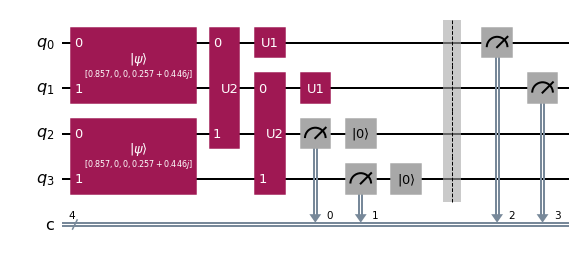

Text(0, 0.5, 'P')

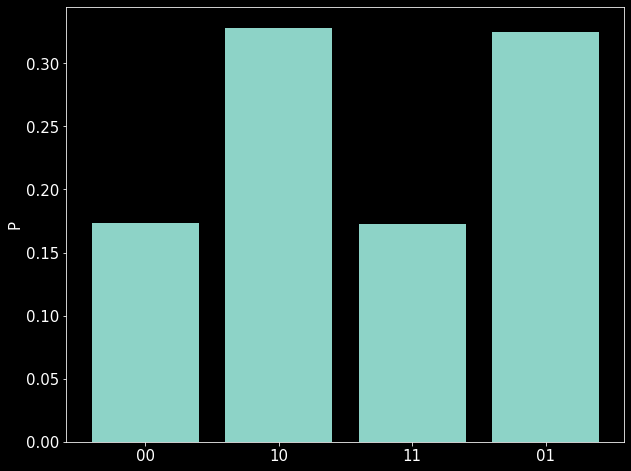

In [8]:
n_iter = 1
z = 0.6*np.exp(np.pi/3)
U2 = [[1,0,0,0],
      [0,0,0,1],
      [0,0,1,0],
      [0,1,0,0]];
U1 = [[1/np.sqrt(2),1/np.sqrt(2)],
      [1/np.sqrt(2),-1/np.sqrt(2)]];
c = [5/np.sqrt(34),
     0,
     0,
     3*np.exp(1j*np.pi/3)/np.sqrt(34)]

qc,counts = circuit(n_iter,unitary2=U2,unitary1=U1,c=c)

display(qc.draw('mpl',style={'name':'iqx'}))

plt.bar(counts.keys(), counts.values())
plt.ylabel('P')

Which is consistent with 

$P(|00\rangle) = P(|11\rangle) = 0.17 $

$P(|01\rangle) = P(|10\rangle) = 0.33 $

### More iterations

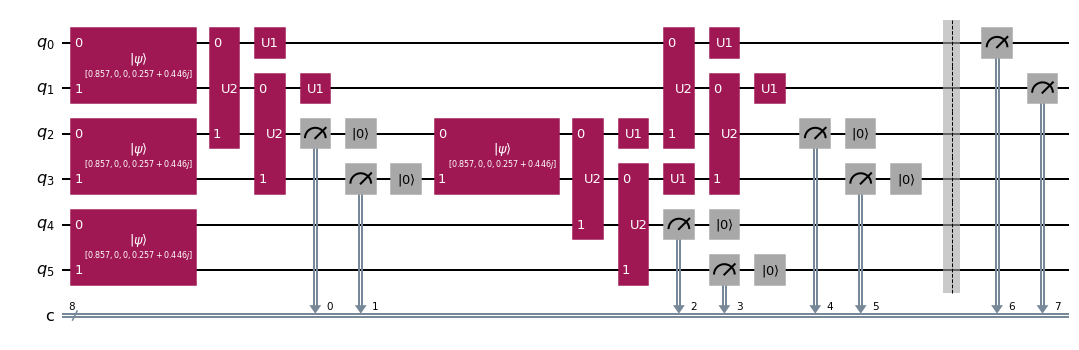

Text(0, 0.5, 'P')

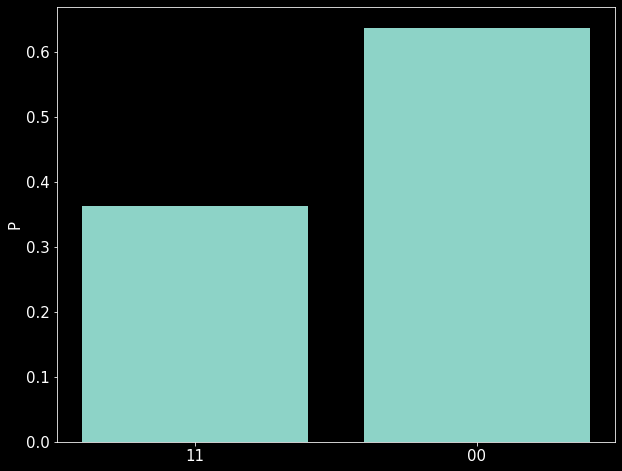

In [9]:
n_iter = 2

qc,counts = circuit(n_iter,unitary2=U2,unitary1=U1,c=c)
display(qc.draw('mpl',style='iqx'))
plt.bar(counts.keys(), counts.values())
plt.ylabel('P')